# Visualize pose space before and after NN

In [102]:
import cv2
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pynndescent import NNDescent
from sklearn.decomposition import PCA
from aging.size_norm.data import clean
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend
import warnings
warnings.simplefilter('ignore')
import umap

In [2]:
ONTOGENY_AGE_CMAP = "cubehelix"

In [3]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "size-normalization", tight_layout=False, dpi=600)

In [4]:
def smooth_clean(frame):
    frame = clean(frame)
    frame = cv2.GaussianBlur(frame, (21, 21), 1.5, 1)
    return frame

In [5]:
thinning = 5

In [6]:
tmp = joblib.load("/n/scratch3/users/w/wg41/aging-aligned-frames.p")
all_frames = tmp["frames"]
all_recon_frames = tmp["recon"]

## Visualize manifold in a few different ways

Label by age

- PCA
- UMAP

In [54]:
np.random.seed(0)
pca = PCA(n_components=10)
pca.fit(
    np.concatenate(
        [
            v[np.random.permutation(np.arange(len(v)))[:2_500]]
            for v in all_frames.values()
        ],
        axis=0,
    ).reshape(-1, (80 * 80))
)

PCA(n_components=10)

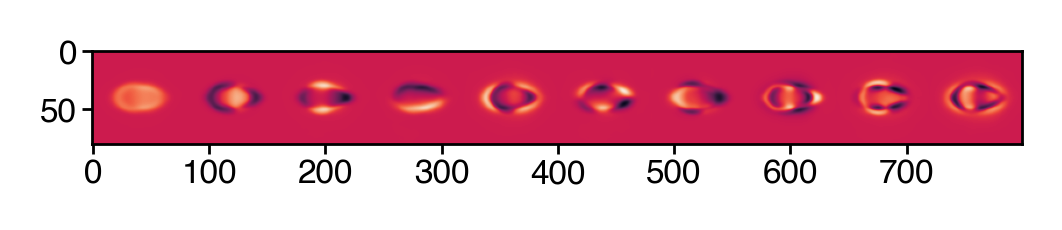

In [55]:
components = pca.components_.reshape(len(pca.components_), 80, 80)

# components = np.concatenate([components[:10], components[10:]], axis=1)
components = np.concatenate(components, axis=1)

plt.imshow(components)

(0.4, 1.0)

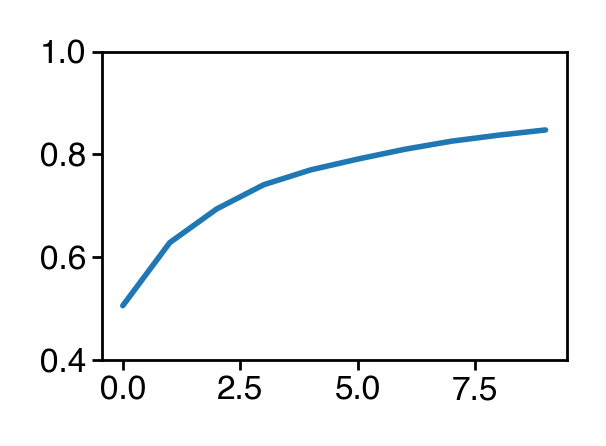

In [56]:
fig = plt.figure(figsize=(1.5, 1))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(0.4, 1)

In [57]:
x = []
y = []
for k, v in all_frames.items():
    v = v[np.random.permutation(np.arange(len(v)))[:7_500]]
    y.extend([k[-1]] * len(v))
    x.append(v)
x = np.concatenate(x, axis=0)
x = x.reshape(len(x), -1)
y = np.array(y)

pre_x_pcs = np.concatenate(
    [pca.transform(batch) for batch in np.array_split(x, len(x) // 50_000)], axis=0
)

In [12]:
pc_df = pd.DataFrame(dict(enumerate(StandardScaler().fit_transform(pre_x_pcs).T)))
pc_df['age'] = y

avg_pc = pc_df.groupby('age').mean()
raw_dists = pdist(avg_pc.to_numpy(), metric='euclidean')

In [13]:
permutation = np.random.permutation(np.arange(len(pre_x_pcs[::thinning])))

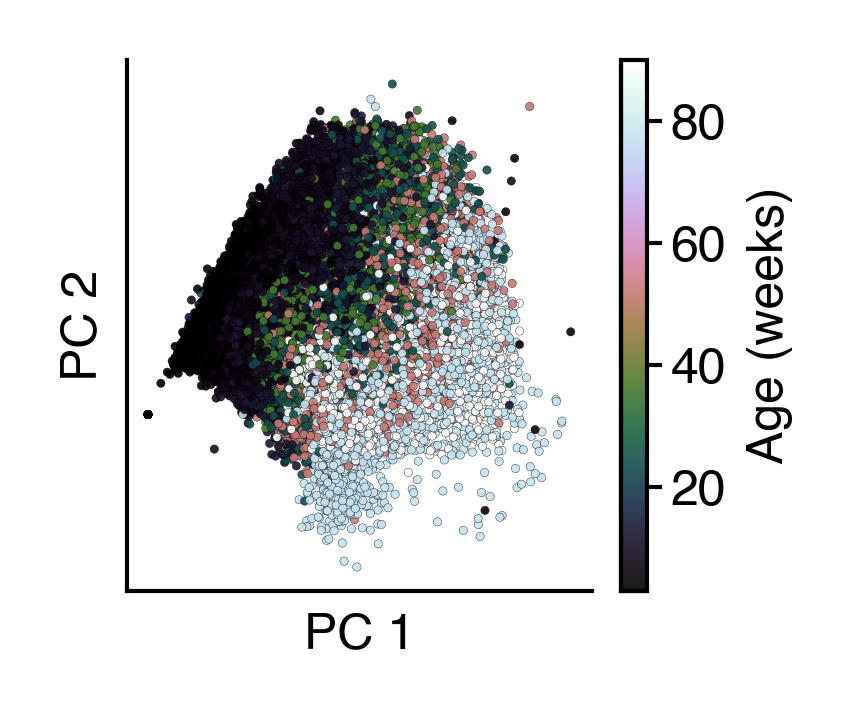

In [14]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *pre_x_pcs[::thinning, :2][permutation].T,
    c=y[::thinning][permutation],
    cmap=ONTOGENY_AGE_CMAP,
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
)
fig.colorbar(im, label="Age (weeks)", ax=ax)
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, 'pre-model-pcs-across-age', dpi=600);

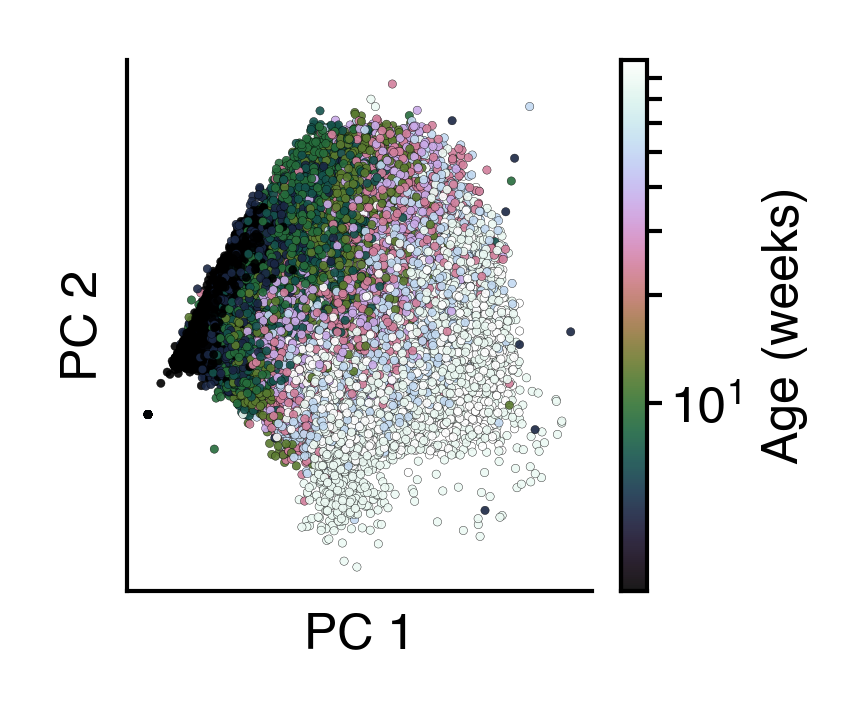

In [19]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *pre_x_pcs[::thinning, :2][permutation].T,
    c=y[::thinning][permutation],
    cmap=ONTOGENY_AGE_CMAP,
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
    norm='log'
)
cb = fig.colorbar(im, label="Age (weeks)", ax=ax)
cb.set_ticks(np.arange(10, pc_df['age'].max(), 10, dtype='int'))
cb.set_ticks([], minor=True)
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, 'pre-model-pcs-across-age-log-cmap', dpi=600);

In [16]:
umap_mdl = umap.UMAP(random_state=0)
latents = umap_mdl.fit_transform(pre_x_pcs[::thinning])

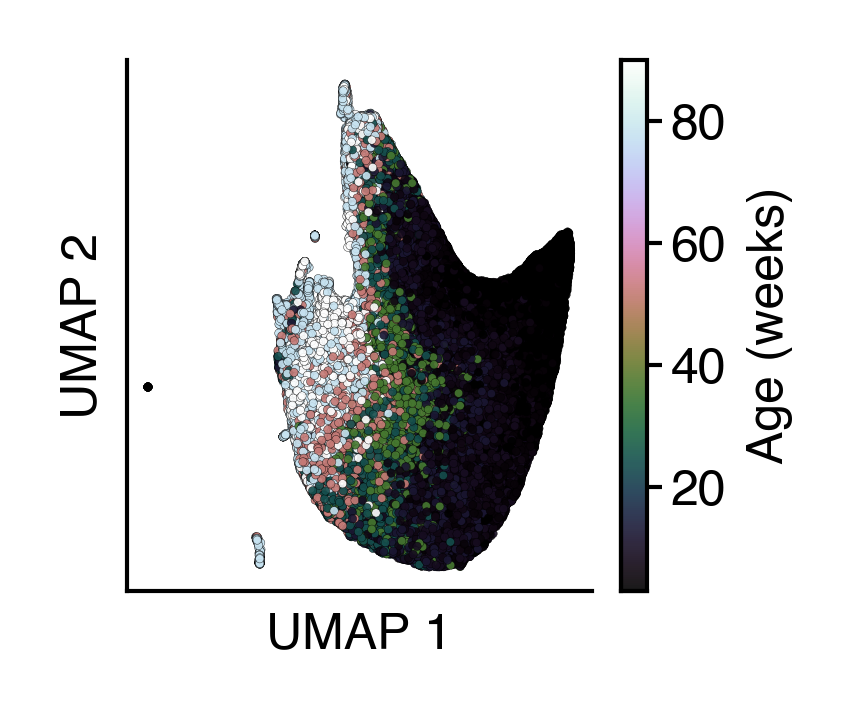

In [20]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *latents[permutation].T,
    c=y[::thinning][permutation],
    cmap="cubehelix",
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
)
fig.colorbar(im, label="Age (weeks)", ax=ax)
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, 'pre-model-umap-across-age', dpi=600);

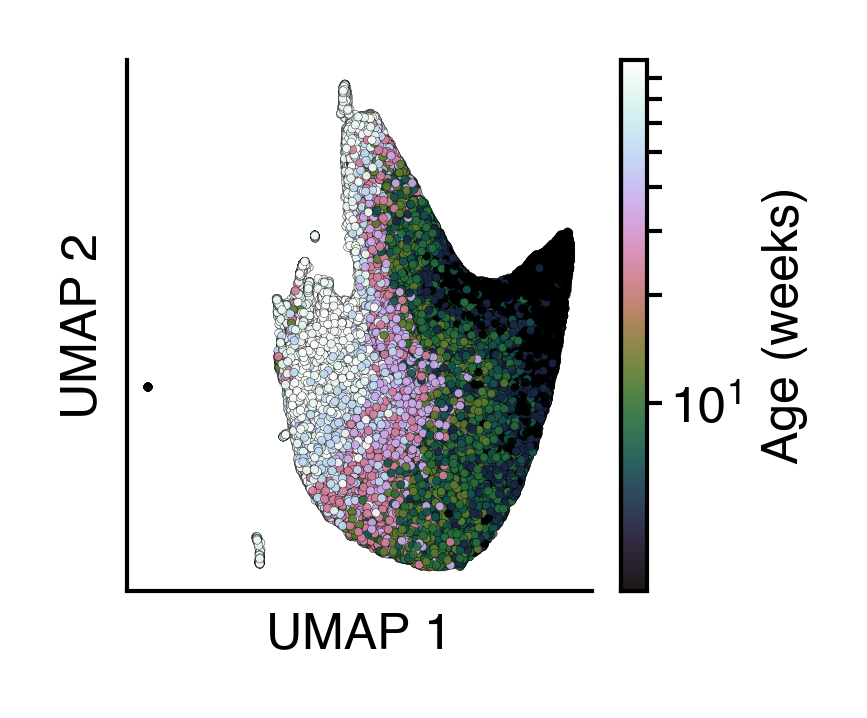

In [21]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *latents[permutation].T,
    c=y[::thinning][permutation],
    cmap="cubehelix",
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
    norm='log',
)
cb = fig.colorbar(im, label="Age (weeks)", ax=ax)
cb.set_ticks(np.arange(10, pc_df['age'].max(), 10, dtype='int'))
cb.set_ticks([], minor=True)
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, 'pre-model-umap-across-age-log-cmap', dpi=600);

## After NN

In [58]:
np.random.seed(0)
pca = PCA(n_components=10)
pca.fit(
    np.concatenate(
        [
            v[np.random.permutation(np.arange(len(v)))[:2_500]]
            for v in all_recon_frames.values()
        ],
        axis=0,
    ).reshape(-1, (80 * 80))
)

PCA(n_components=10)

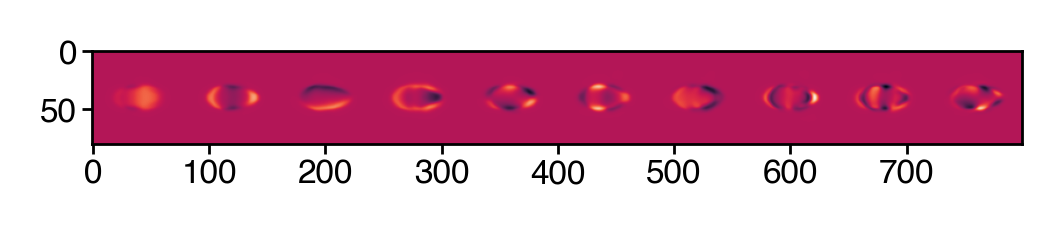

In [59]:
components = pca.components_.reshape(len(pca.components_), 80, 80)

# components = np.concatenate([components[:10], components[10:]], axis=1)
components = np.concatenate(components, axis=1)

plt.imshow(components)

(0.4, 1.0)

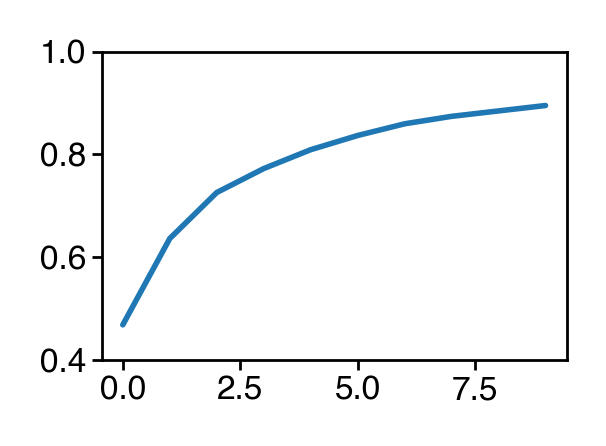

In [60]:
fig = plt.figure(figsize=(1.5, 1))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(0.4, 1)

In [61]:
x = []
y = []
for k, v in all_recon_frames.items():
    v = v[np.random.permutation(np.arange(len(v)))[:7_500]]
    y.extend([k[-1]] * len(v))
    x.append(v)
x = np.concatenate(x, axis=0)
x = x.reshape(len(x), -1)
y = np.array(y)

post_x_pcs = np.concatenate(
    [pca.transform(batch) for batch in np.array_split(x, len(x) // 50_000)], axis=0
)

In [27]:
pc_df = pd.DataFrame(dict(enumerate(StandardScaler().fit_transform(post_x_pcs).T)))
pc_df['age'] = y

avg_pc = pc_df.groupby('age').mean()
xform_dists = pdist(avg_pc.to_numpy(), metric='euclidean')

In [28]:
permutation = np.random.permutation(np.arange(len(post_x_pcs[::thinning])))

In [ ]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *post_x_pcs[::thinning, :2][permutation].T,
    c=y[::thinning][permutation],
    cmap=ONTOGENY_AGE_CMAP,
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
)
fig.colorbar(im, label="Age (weeks)", ax=ax)
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, 'post-model-pcs-across-age', dpi=600);

In [ ]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *post_x_pcs[::thinning, :2][permutation].T,
    c=y[::thinning][permutation],
    cmap=ONTOGENY_AGE_CMAP,
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
    norm='log'
)
cb = fig.colorbar(im, label="Age (weeks)", ax=ax)
cb.set_ticks(np.arange(10, pc_df['age'].max(), 10, dtype='int'))
cb.set_ticks([], minor=True)
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, 'post-model-pcs-across-age-log-cmap', dpi=600);

In [31]:
umap_mdl = umap.UMAP(random_state=0)
latents = umap_mdl.fit_transform(post_x_pcs[::thinning])

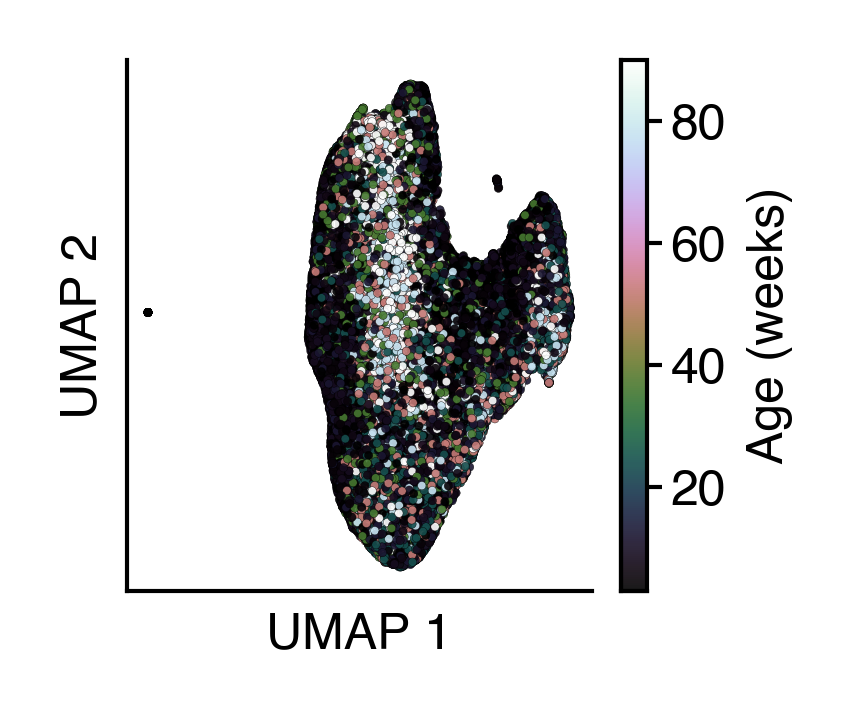

In [32]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *latents[permutation].T,
    c=y[::thinning][permutation],
    cmap="cubehelix",
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
)
fig.colorbar(im, label="Age (weeks)", ax=ax)
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, "post-model-umap-across-age", dpi=600);

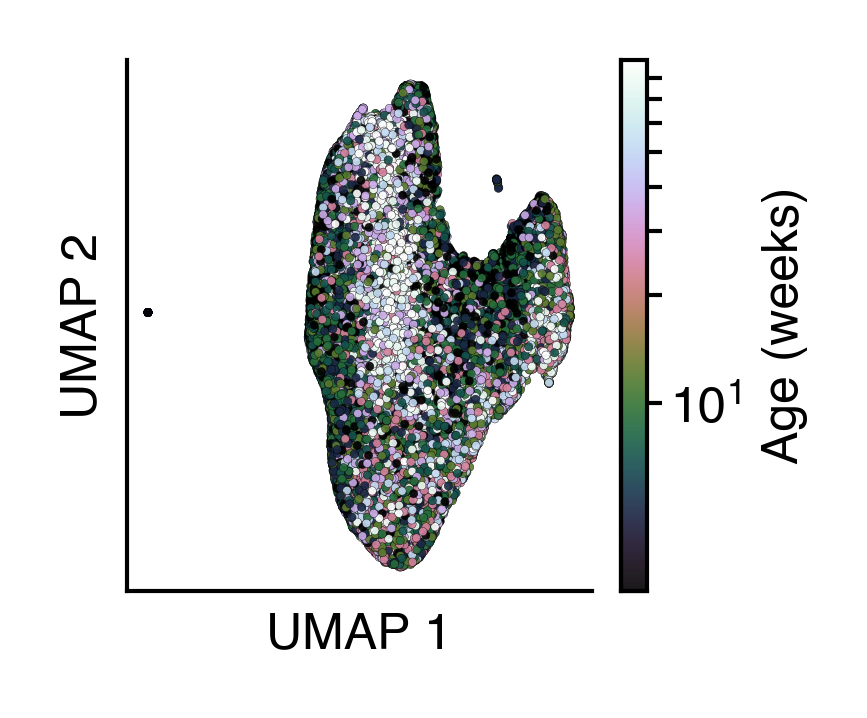

In [34]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *latents[permutation].T,
    c=y[::thinning][permutation],
    cmap="cubehelix",
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
    norm="log",
)
cb = fig.colorbar(im, label="Age (weeks)", ax=ax)
cb.set_ticks(np.arange(10, pc_df["age"].max(), 10, dtype="int"))
cb.set_ticks([], minor=True)
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, "post-model-umap-across-age-log-cmap", dpi=600);

## Comparison of nearest-neighbor ages

In [125]:
from scipy.spatial.distance import jensenshannon

In [135]:
pre_index = NNDescent(pre_x_pcs, n_neighbors=21)
post_index = NNDescent(post_x_pcs, n_neighbors=21)
pre_y = y.copy()
post_y = y.copy()

In [136]:
nn = pre_index.neighbor_graph[0]
avg_nn_age_pre = np.abs(pre_y[nn[:, :1]] - pre_y[nn[:, 1:]])

nn = post_index.neighbor_graph[0]
avg_nn_age_post = np.abs(post_y[nn[:, :1]] - post_y[nn[:, 1:]])

In [137]:
n_neigh_pre = (avg_nn_age_pre > 0).sum(axis=1)
n_neigh_post = (avg_nn_age_post > 0).sum(axis=1)

In [138]:
jensenshannon(np.histogram(n_neigh_pre, bins=np.arange(22) - 0.5)[0],  np.histogram(n_neigh_post, bins=np.arange(22) - 0.5)[0])

0.2743246256418892

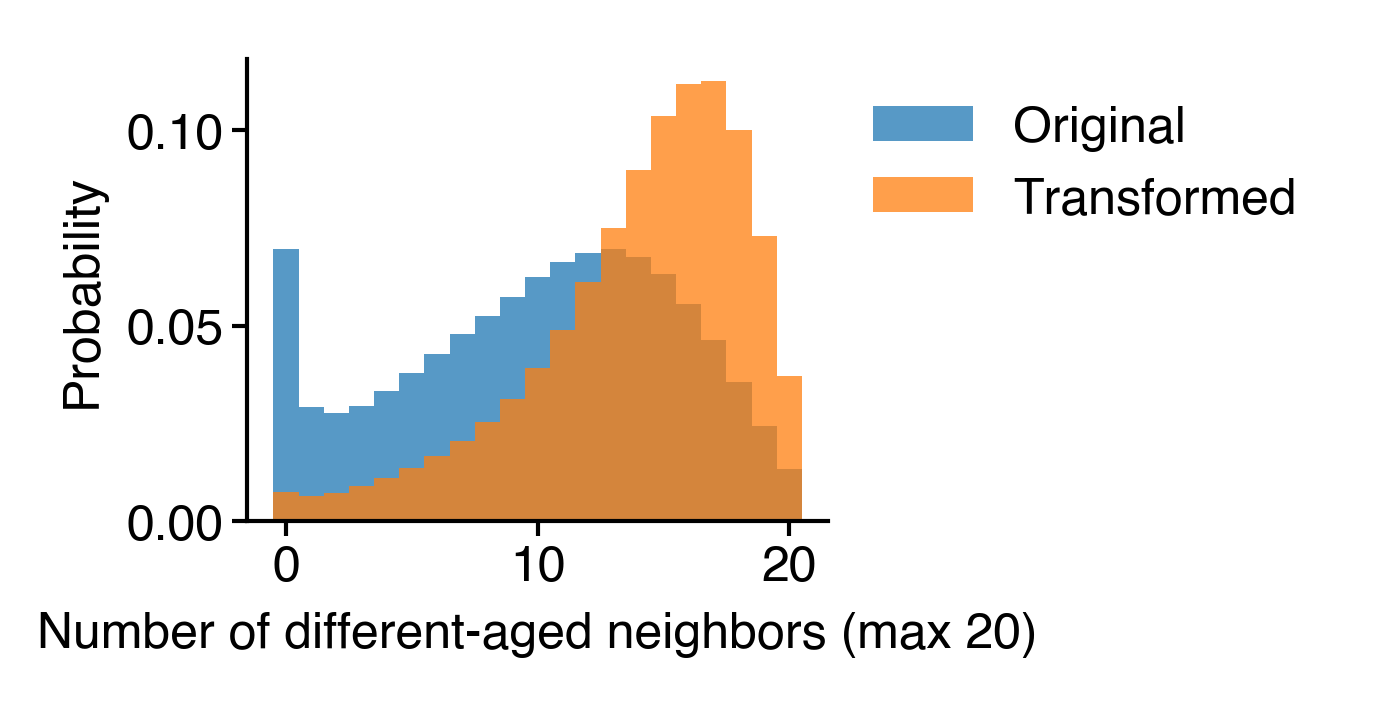

In [145]:
fig = figure(1.25, 1)
ax = sns.histplot(
    n_neigh_pre,
    bins=np.arange(22) - 0.5,
    element="step",
    label="Original",
    stat="probability",
    lw=0,
)
ax = sns.histplot(
    n_neigh_post,
    bins=np.arange(22) - 0.5,
    element="step",
    label="Transformed",
    stat="probability",
    lw=0,
)
ax.set(xlabel="Number of different-aged neighbors (max 20)")
legend(ax)
sns.despine()
saver(fig, "nearest-neighbor-distributions");

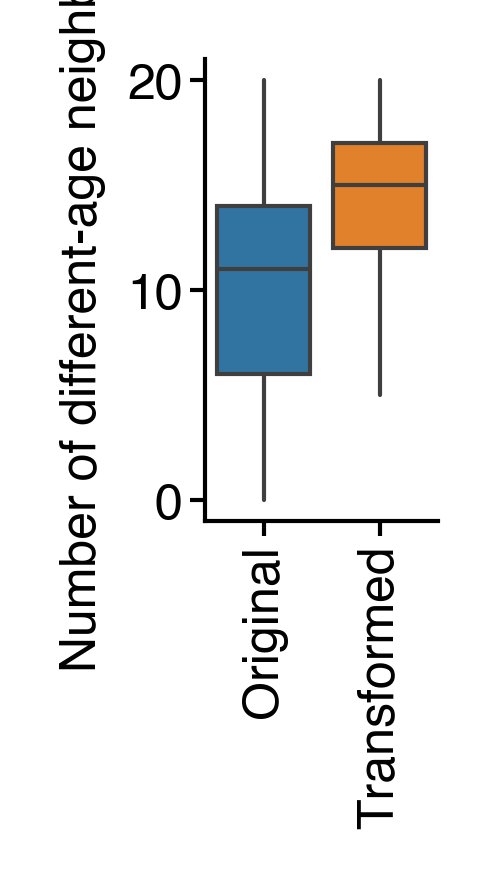

In [142]:
fig = figure(0.5, 1)
ax = sns.boxplot(
    data=[(avg_nn_age_pre > 0).sum(axis=1), (avg_nn_age_post > 0).sum(axis=1)],
    showcaps=False,
    showfliers=False,
    linewidth=0.5,
)
ax.set(
    ylabel="Number of different-age neighbors", xticklabels=["Original", "Transformed"]
)
plt.xticks(rotation=90)
sns.despine()
# saver(fig, "nearest-neighbor-age-diff");

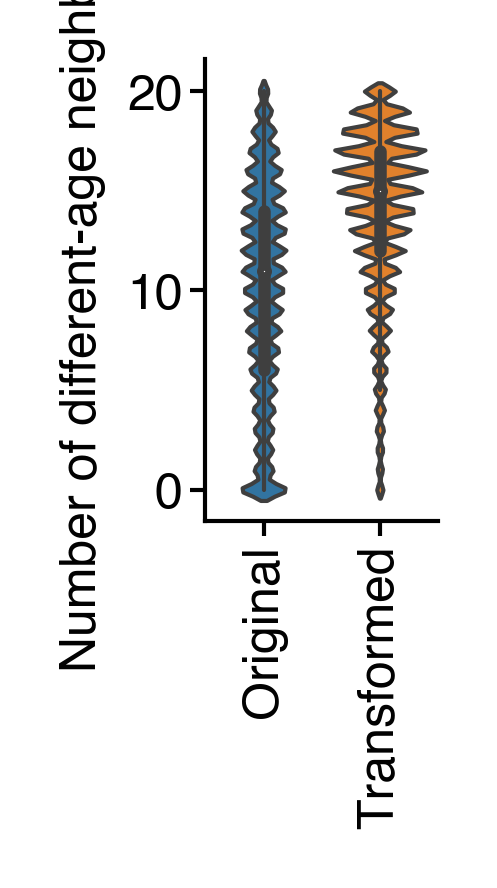

In [143]:
fig = figure(0.5, 1)
ax = sns.violinplot(
    data=[(avg_nn_age_pre > 0).sum(axis=1), (avg_nn_age_post > 0).sum(axis=1)],
    linewidth=0.5, bw=0.05
)
ax.set(
    ylabel="Number of different-age neighbors", xticklabels=["Original", "Transformed"]
)
plt.xticks(rotation=90)
sns.despine()
# saver(fig, "nearest-neighbor-age-diff-violin");

In [130]:
opt = {}
hists = {}
for num_neigh in range(5, 50, 5):
    pre_index = NNDescent(pre_x_pcs, n_neighbors=num_neigh + 1)
    post_index = NNDescent(post_x_pcs, n_neighbors=num_neigh + 1)

    nn = pre_index.neighbor_graph[0]
    avg_nn_age_pre = np.abs(pre_y[nn[:, :1]] - pre_y[nn[:, 1:]])

    nn = post_index.neighbor_graph[0]
    avg_nn_age_post = np.abs(post_y[nn[:, :1]] - post_y[nn[:, 1:]])

    n_neigh_pre = (avg_nn_age_pre > 0).sum(axis=1)
    n_neigh_post = (avg_nn_age_post > 0).sum(axis=1)

    h1 = np.histogram(n_neigh_pre, bins=np.arange(num_neigh + 2) - 0.5)[0]
    h2 = np.histogram(n_neigh_post, bins=np.arange(num_neigh + 2) - 0.5)[0]
    jsd = jensenshannon(h1, h2)
    opt[num_neigh] = jsd
    hists[num_neigh] = (h1, h2)
    print(num_neigh, jsd)

5 0.2217223172262391
10 0.24910496827438983
15 0.2640973820447405
20 0.27433731067816963
25 0.281950419657605
30 0.2880236443631206
35 0.29318929973900415
40 0.29755461398094524
45 0.3013409165833563


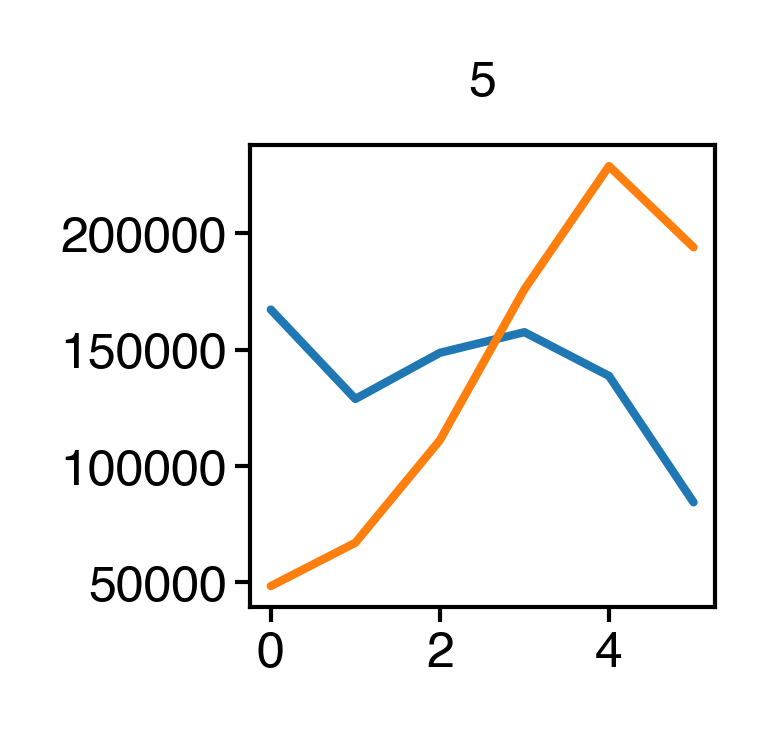

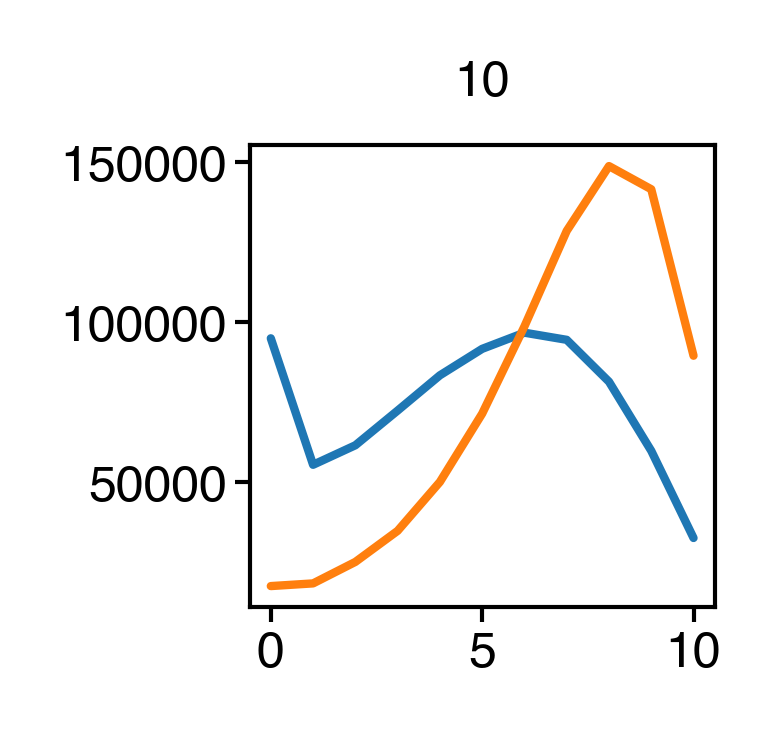

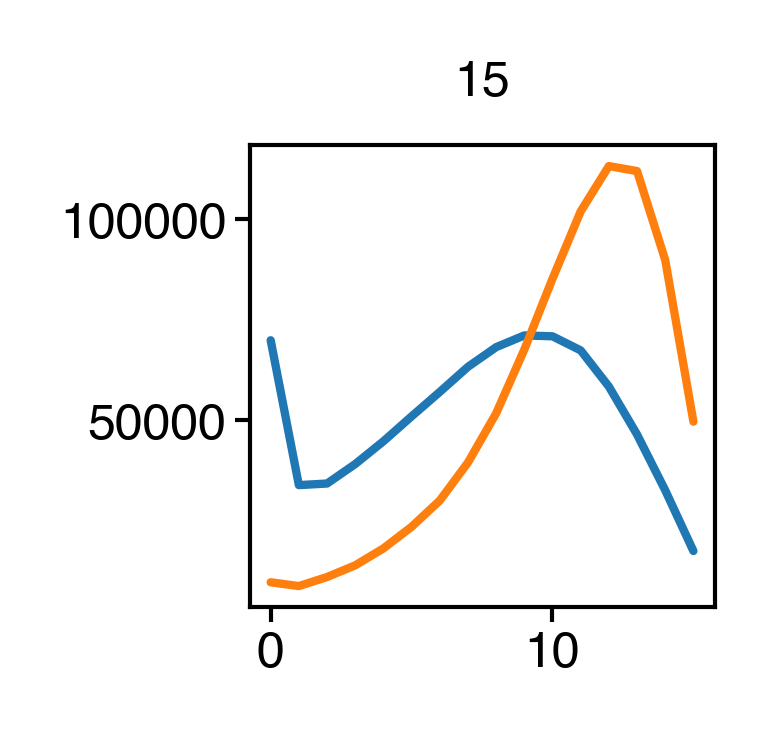

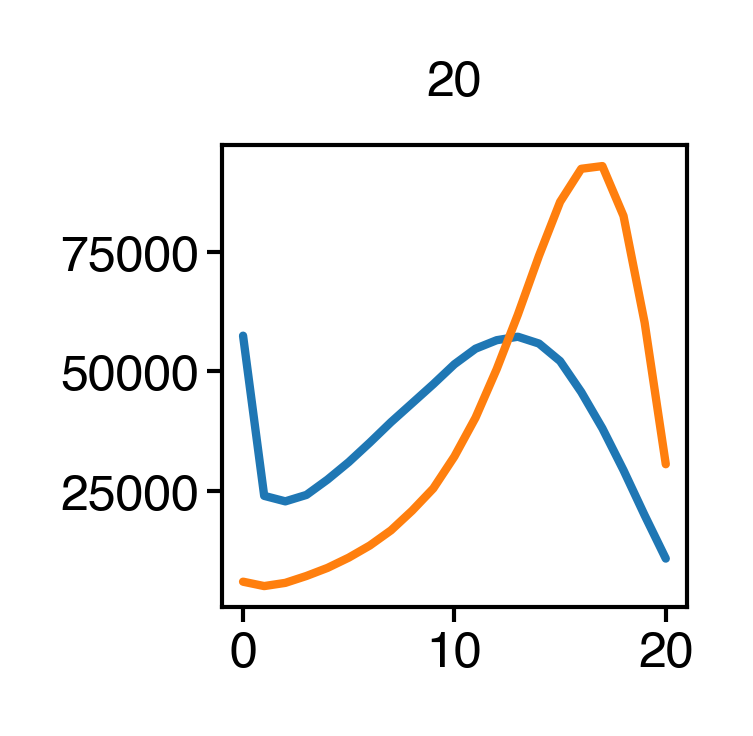

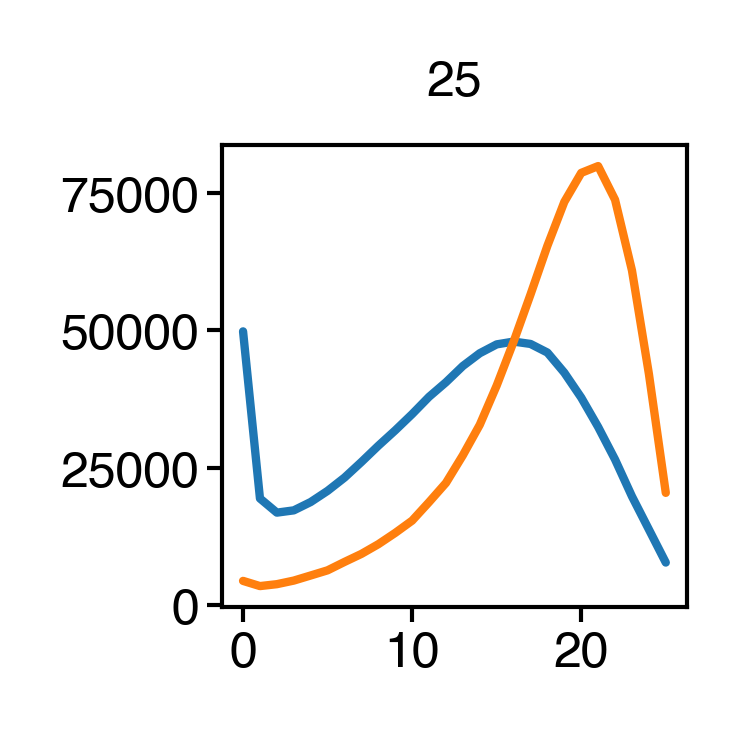

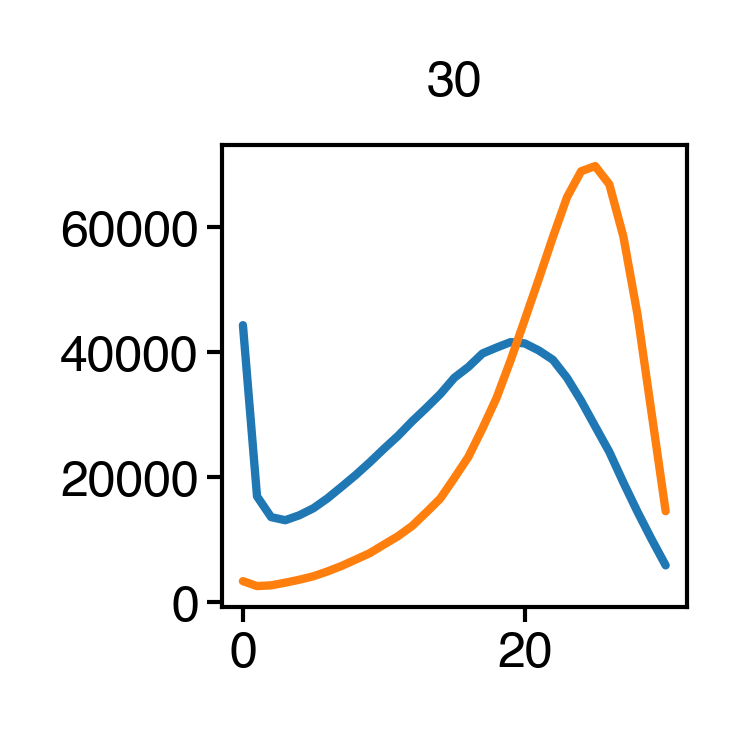

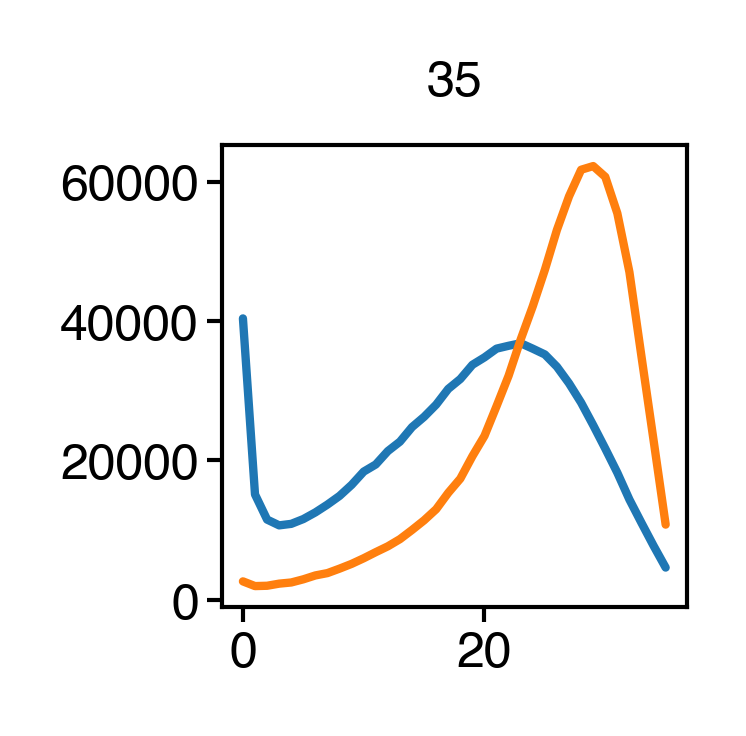

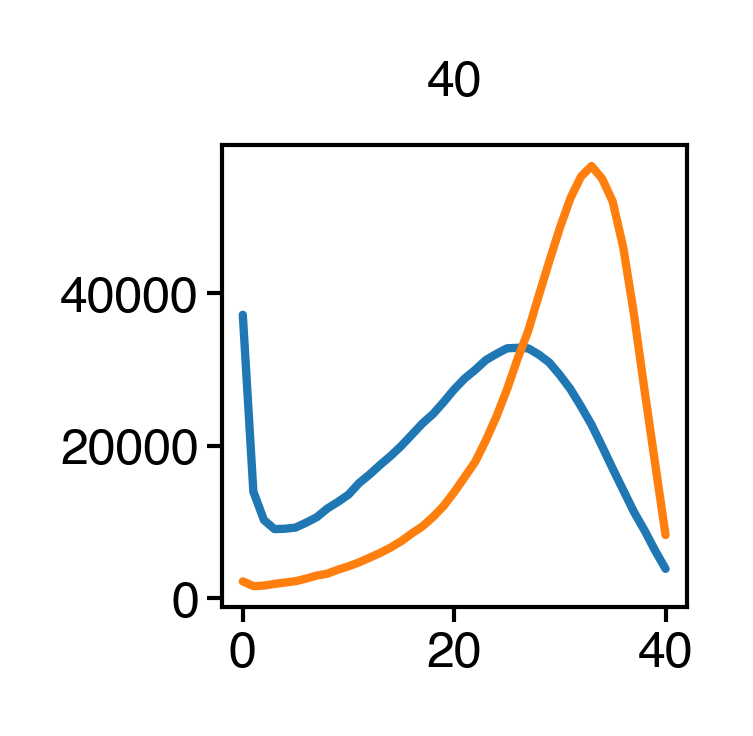

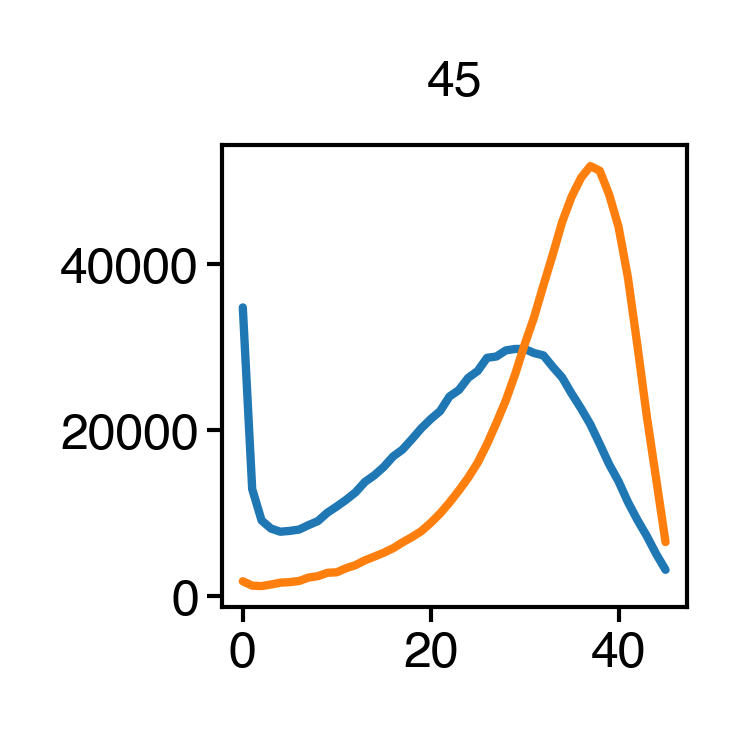

In [133]:
for k, (h1, h2) in hists.items():
    figure(1, 1)
    plt.plot(h1)
    plt.plot(h2)
    plt.title(k)

<Axes: >

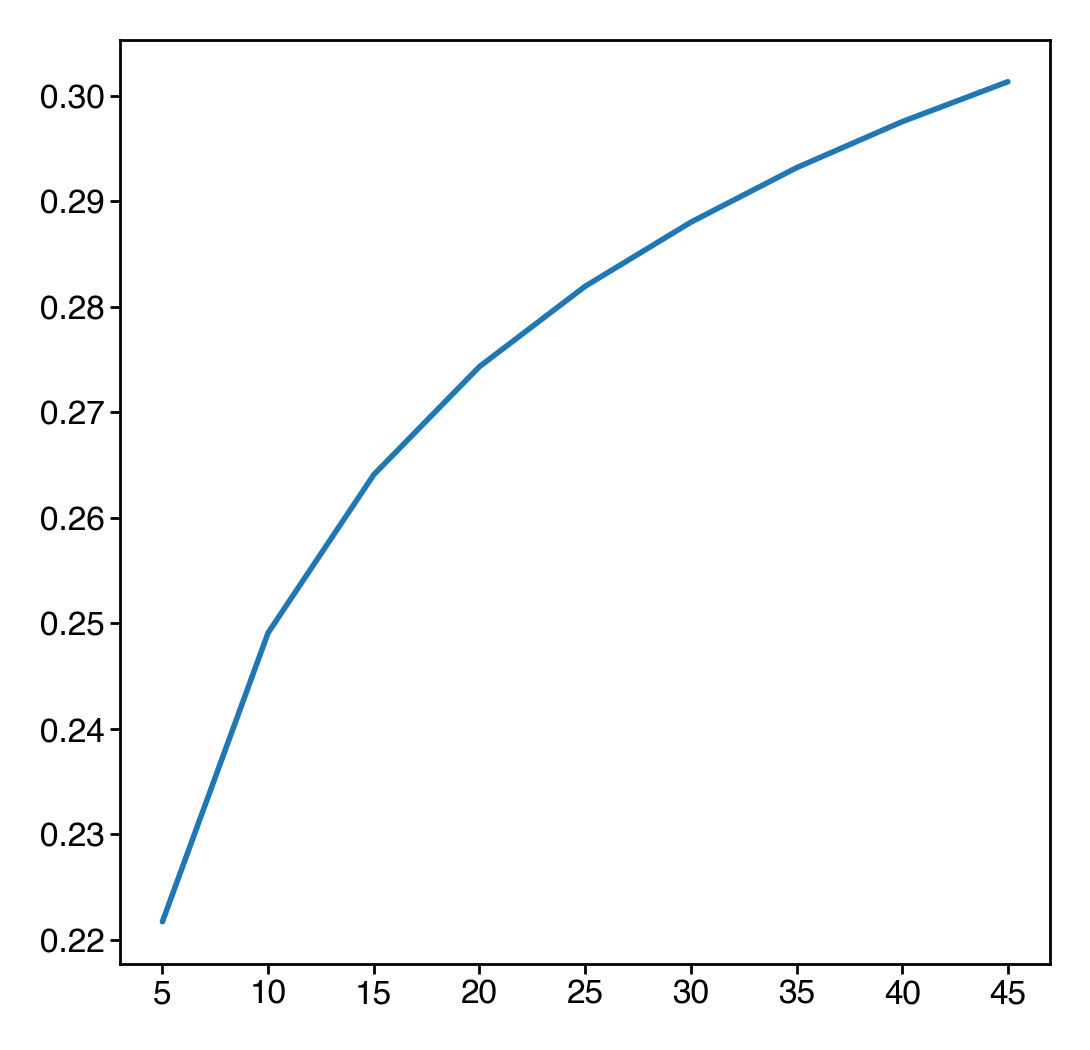

In [134]:
pd.Series(opt).plot()

## TODO: use holoviews to visualize frames at different points